# 操作1

In [149]:
%%HTML
<style>
    body {
        --vscode-font-family: 霞鹜文楷, Consolas, 'Courier New', monospace
    }
</style>

In [150]:
import warnings
warnings.filterwarnings('ignore')

In [151]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [152]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.repository.datasets import dataset_recipes, get_dataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import MultivariateEvaluator

In [153]:
from pts.model.time_grad import TimeGradEstimator
from pytorch_lightning import Trainer

In [154]:
from diffusers import DEISMultistepScheduler

In [155]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [156]:
def plot(target, forecast, prediction_length, prediction_intervals=(50.0, 90.0), color='g', fname=None):
    label_prefix = ""
    rows = 4
    cols = 4
    fig, axs = plt.subplots(rows, cols, figsize=(24, 24))
    axx = axs.ravel()
    seq_len, target_dim = target.shape
    
    ps = [50.0] + [
            50.0 + f * c / 2.0 for c in prediction_intervals for f in [-1.0, +1.0]
        ]
        
    percentiles_sorted = sorted(set(ps))
    
    def alpha_for_percentile(p):
        return (p / 100.0) ** 0.3
        
    for dim in range(0, min(rows * cols, target_dim)):
        ax = axx[dim]

        target[-2 * prediction_length :][dim].plot(ax=ax)
        
        ps_data = [forecast.quantile(p / 100.0)[:,dim] for p in percentiles_sorted]
        i_p50 = len(percentiles_sorted) // 2
        
        p50_data = ps_data[i_p50]
        p50_series = pd.Series(data=p50_data, index=forecast.index)
        p50_series.plot(color=color, ls="-", label=f"{label_prefix}median", ax=ax)
        
        for i in range(len(percentiles_sorted) // 2):
            ptile = percentiles_sorted[i]
            alpha = alpha_for_percentile(ptile)
            ax.fill_between(
                forecast.index,
                ps_data[i],
                ps_data[-i - 1],
                facecolor=color,
                alpha=alpha,
                interpolate=True,
            )
            # Hack to create labels for the error intervals.
            # Doesn't actually plot anything, because we only pass a single data point
            pd.Series(data=p50_data[:1], index=forecast.index[:1]).plot(
                color=color,
                alpha=alpha,
                linewidth=10,
                label=f"{label_prefix}{100 - ptile * 2}%",
                ax=ax,
            )

    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]    
    axx[0].legend(legend, loc="upper left")
    
    if fname is not None:
        plt.savefig(fname, bbox_inches='tight', pad_inches=0.05)

# 数据准备

In [157]:
import pandas as pd
import matplotlib.pyplot as plt
from gluonts.dataset.common import ListDataset
from gluonts.dataset.split import split
df = pd.read_csv(  "./mydata/my_groundtruth.csv")
df_input = df[['timestamp', 'c1', 'c2', 'c3', 'c4', 'c5','c6']]
df_input = df_input.set_index('timestamp')

In [158]:
df_input['c6']

timestamp
2000-01-01 00:00:00   -0.024562
2000-01-01 00:05:00   -0.024499
2000-01-01 00:10:00   -0.024461
2000-01-01 00:15:00   -0.024461
2000-01-01 00:20:00   -0.024464
                         ...   
2007-12-10 21:55:00   -1.601259
2007-12-10 22:00:00   -1.605744
2007-12-10 22:05:00   -1.614782
2007-12-10 22:10:00   -1.614782
2007-12-10 22:15:00   -1.614782
Name: c6, Length: 835468, dtype: float64

In [159]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
train_grouper_NlctGt = MultivariateGrouper(max_target_dim=6)

test_grouper_NlctGt = MultivariateGrouper( max_target_dim=6)

In [160]:
train_time='2003-08-27 13:15:00'
test_start_time='2003-08-27 13:20:00'
test_end_time='2004-08-27 13:15:00'


In [161]:
training_data = train_grouper_NlctGt([
    ListDataset(
     [{"start": df_input.index[0], "target": df_input.c1[:train_time]}],
     freq = "5min"
    )[0],
    ListDataset(
     [{"start": df_input.index[0], "target": df_input.c2[:train_time]}],
     freq = "5min"
    )[0],
    ListDataset(
     [{"start": df_input.index[0], "target": df_input.c3[:train_time]}],
     freq = "5min"
    )[0],
    ListDataset(
     [{"start": df_input.index[0], "target": df_input.c4[:train_time]}],
     freq = "5min"
    )[0],
    ListDataset(
     [{"start": df_input.index[0], "target": df_input.c5[:train_time]}],
     freq = "5min"
    )[0],
    ListDataset(
     [{"start": df_input.index[0], "target": df_input.c6[:train_time]}],
     freq = "5min"
    )[0],
])

In [162]:
test_data = test_grouper_NlctGt([
    ListDataset(
     [{"start": df_input.index[0], "target": df_input.c1[test_start_time:test_end_time]}],
     freq = "5min"
    )[0],
    ListDataset(
     [{"start": df_input.index[0], "target": df_input.c2[test_start_time:test_end_time]}],
     freq = "5min"
    )[0],
    ListDataset(
     [{"start": df_input.index[0], "target": df_input.c3[test_start_time:test_end_time]}],
     freq = "5min"
    )[0],
    ListDataset(
     [{"start": df_input.index[0], "target": df_input.c4[test_start_time:test_end_time]}],
     freq = "5min"
    )[0],
    ListDataset(
     [{"start": df_input.index[0], "target": df_input.c5[test_start_time:test_end_time]}],
     freq = "5min"
    )[0],
    ListDataset(
     [{"start": df_input.index[0], "target": df_input.c6[test_start_time:test_end_time]}],
     freq = "5min"
    )[0],
])

In [163]:
scheduler = DEISMultistepScheduler(
    num_train_timesteps=150,
    beta_end=0.1,
)
estimator_NlctGt = TimeGradEstimator(
    input_size=6,
    hidden_size=64,
    num_layers=2,
    dropout_rate=0.1,
    lags_seq=[1],
    scheduler=scheduler,
    num_inference_steps=149,
    prediction_length=12,
    context_length=36,
    freq='5min',
    scaling="mean",
    trainer_kwargs=dict(max_epochs=20, accelerator="gpu", devices="1"),
)


# 训练开始

In [165]:
predictor_NlctGt = estimator_NlctGt.train(training_data, num_workers=8)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type          | Params | Mode  | In sizes                                                         | Out sizes      
-------------------------------------------------------------------------------------------------------------------------------------
0 | model | TimeGradModel | 72.3 K | train | [[1, 1], [1, 1], [1, 36, 6], [1, 36, 6], [1, 36, 6], [1, 12, 6]] | [1, 100, 12, 6]
-------------------------------------------------------------------------------------------------------------------------------------
72.3 K    Trainable params
0         Non-trainable params
72.3 K    Total params
0.289     Total estimated model params size (MB)


Epoch 0: |          | 50/? [06:16<00:00,  0.13it/s, v_num=31, train_loss=0.349]

Epoch 0, global step 50: 'train_loss' reached 0.34875 (best 0.34875), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_31/checkpoints/epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [06:36<00:00,  0.13it/s, v_num=31, train_loss=0.158]

Epoch 1, global step 100: 'train_loss' reached 0.15780 (best 0.15780), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_31/checkpoints/epoch=1-step=100.ckpt' as top 1


Epoch 2: |          | 50/? [06:49<00:00,  0.12it/s, v_num=31, train_loss=0.124]

Epoch 2, global step 150: 'train_loss' reached 0.12390 (best 0.12390), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_31/checkpoints/epoch=2-step=150.ckpt' as top 1


Epoch 3: |          | 50/? [06:29<00:00,  0.13it/s, v_num=31, train_loss=0.109]

Epoch 3, global step 200: 'train_loss' reached 0.10905 (best 0.10905), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_31/checkpoints/epoch=3-step=200.ckpt' as top 1


Epoch 4: |          | 50/? [06:42<00:00,  0.12it/s, v_num=31, train_loss=0.103]

Epoch 4, global step 250: 'train_loss' reached 0.10335 (best 0.10335), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_31/checkpoints/epoch=4-step=250.ckpt' as top 1


Epoch 5: |          | 50/? [06:35<00:00,  0.13it/s, v_num=31, train_loss=0.095]

Epoch 5, global step 300: 'train_loss' reached 0.09496 (best 0.09496), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_31/checkpoints/epoch=5-step=300.ckpt' as top 1


Epoch 6: |          | 50/? [06:22<00:00,  0.13it/s, v_num=31, train_loss=0.0903]

Epoch 6, global step 350: 'train_loss' reached 0.09029 (best 0.09029), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_31/checkpoints/epoch=6-step=350.ckpt' as top 1


Epoch 7: |          | 50/? [06:33<00:00,  0.13it/s, v_num=31, train_loss=0.0856]

Epoch 7, global step 400: 'train_loss' reached 0.08563 (best 0.08563), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_31/checkpoints/epoch=7-step=400.ckpt' as top 1


Epoch 8: |          | 50/? [06:50<00:00,  0.12it/s, v_num=31, train_loss=0.0787]

Epoch 8, global step 450: 'train_loss' reached 0.07868 (best 0.07868), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_31/checkpoints/epoch=8-step=450.ckpt' as top 1


Epoch 9: |          | 50/? [06:26<00:00,  0.13it/s, v_num=31, train_loss=0.0757]

Epoch 9, global step 500: 'train_loss' reached 0.07568 (best 0.07568), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_31/checkpoints/epoch=9-step=500.ckpt' as top 1


Epoch 10: |          | 50/? [06:44<00:00,  0.12it/s, v_num=31, train_loss=0.073] 

Epoch 10, global step 550: 'train_loss' reached 0.07295 (best 0.07295), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_31/checkpoints/epoch=10-step=550.ckpt' as top 1


Epoch 11: |          | 50/? [06:36<00:00,  0.13it/s, v_num=31, train_loss=0.0719]

Epoch 11, global step 600: 'train_loss' reached 0.07190 (best 0.07190), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_31/checkpoints/epoch=11-step=600.ckpt' as top 1


Epoch 12: |          | 50/? [06:37<00:00,  0.13it/s, v_num=31, train_loss=0.0733]

Epoch 12, global step 650: 'train_loss' was not in top 1


Epoch 13: |          | 50/? [06:31<00:00,  0.13it/s, v_num=31, train_loss=0.0657]

Epoch 13, global step 700: 'train_loss' reached 0.06569 (best 0.06569), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_31/checkpoints/epoch=13-step=700.ckpt' as top 1


Epoch 14: |          | 50/? [06:47<00:00,  0.12it/s, v_num=31, train_loss=0.0642]

Epoch 14, global step 750: 'train_loss' reached 0.06425 (best 0.06425), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_31/checkpoints/epoch=14-step=750.ckpt' as top 1


Epoch 15: |          | 50/? [06:42<00:00,  0.12it/s, v_num=31, train_loss=0.0644]

Epoch 15, global step 800: 'train_loss' was not in top 1


Epoch 16: |          | 50/? [06:42<00:00,  0.12it/s, v_num=31, train_loss=0.0632]

Epoch 16, global step 850: 'train_loss' reached 0.06315 (best 0.06315), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_31/checkpoints/epoch=16-step=850.ckpt' as top 1


Epoch 17: |          | 50/? [06:27<00:00,  0.13it/s, v_num=31, train_loss=0.0619]

Epoch 17, global step 900: 'train_loss' reached 0.06191 (best 0.06191), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_31/checkpoints/epoch=17-step=900.ckpt' as top 1


Epoch 18: |          | 50/? [06:37<00:00,  0.13it/s, v_num=31, train_loss=0.0601]

Epoch 18, global step 950: 'train_loss' reached 0.06010 (best 0.06010), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_31/checkpoints/epoch=18-step=950.ckpt' as top 1


Epoch 19: |          | 50/? [06:39<00:00,  0.13it/s, v_num=31, train_loss=0.0557]

Epoch 19, global step 1000: 'train_loss' reached 0.05569 (best 0.05569), saving model to '/home/songzy/myDL/TimeGrad/timegrad-s4-main/lightning_logs/version_31/checkpoints/epoch=19-step=1000.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: |          | 50/? [06:39<00:00,  0.13it/s, v_num=31, train_loss=0.0557]


In [166]:
forecast_it_NlctGt, ts_it_NlctGt = make_evaluation_predictions(dataset=test_data,
                                                 predictor=predictor_NlctGt,
                                                 num_samples=100)


In [167]:
forecasts_NlctGt = list(forecast_it_NlctGt)
targets_NlctGt = list(ts_it_NlctGt)

In [168]:
forecasts_NlctGt[0].samples.shape

(100, 12, 6)

# 画出预测图

NlctGt


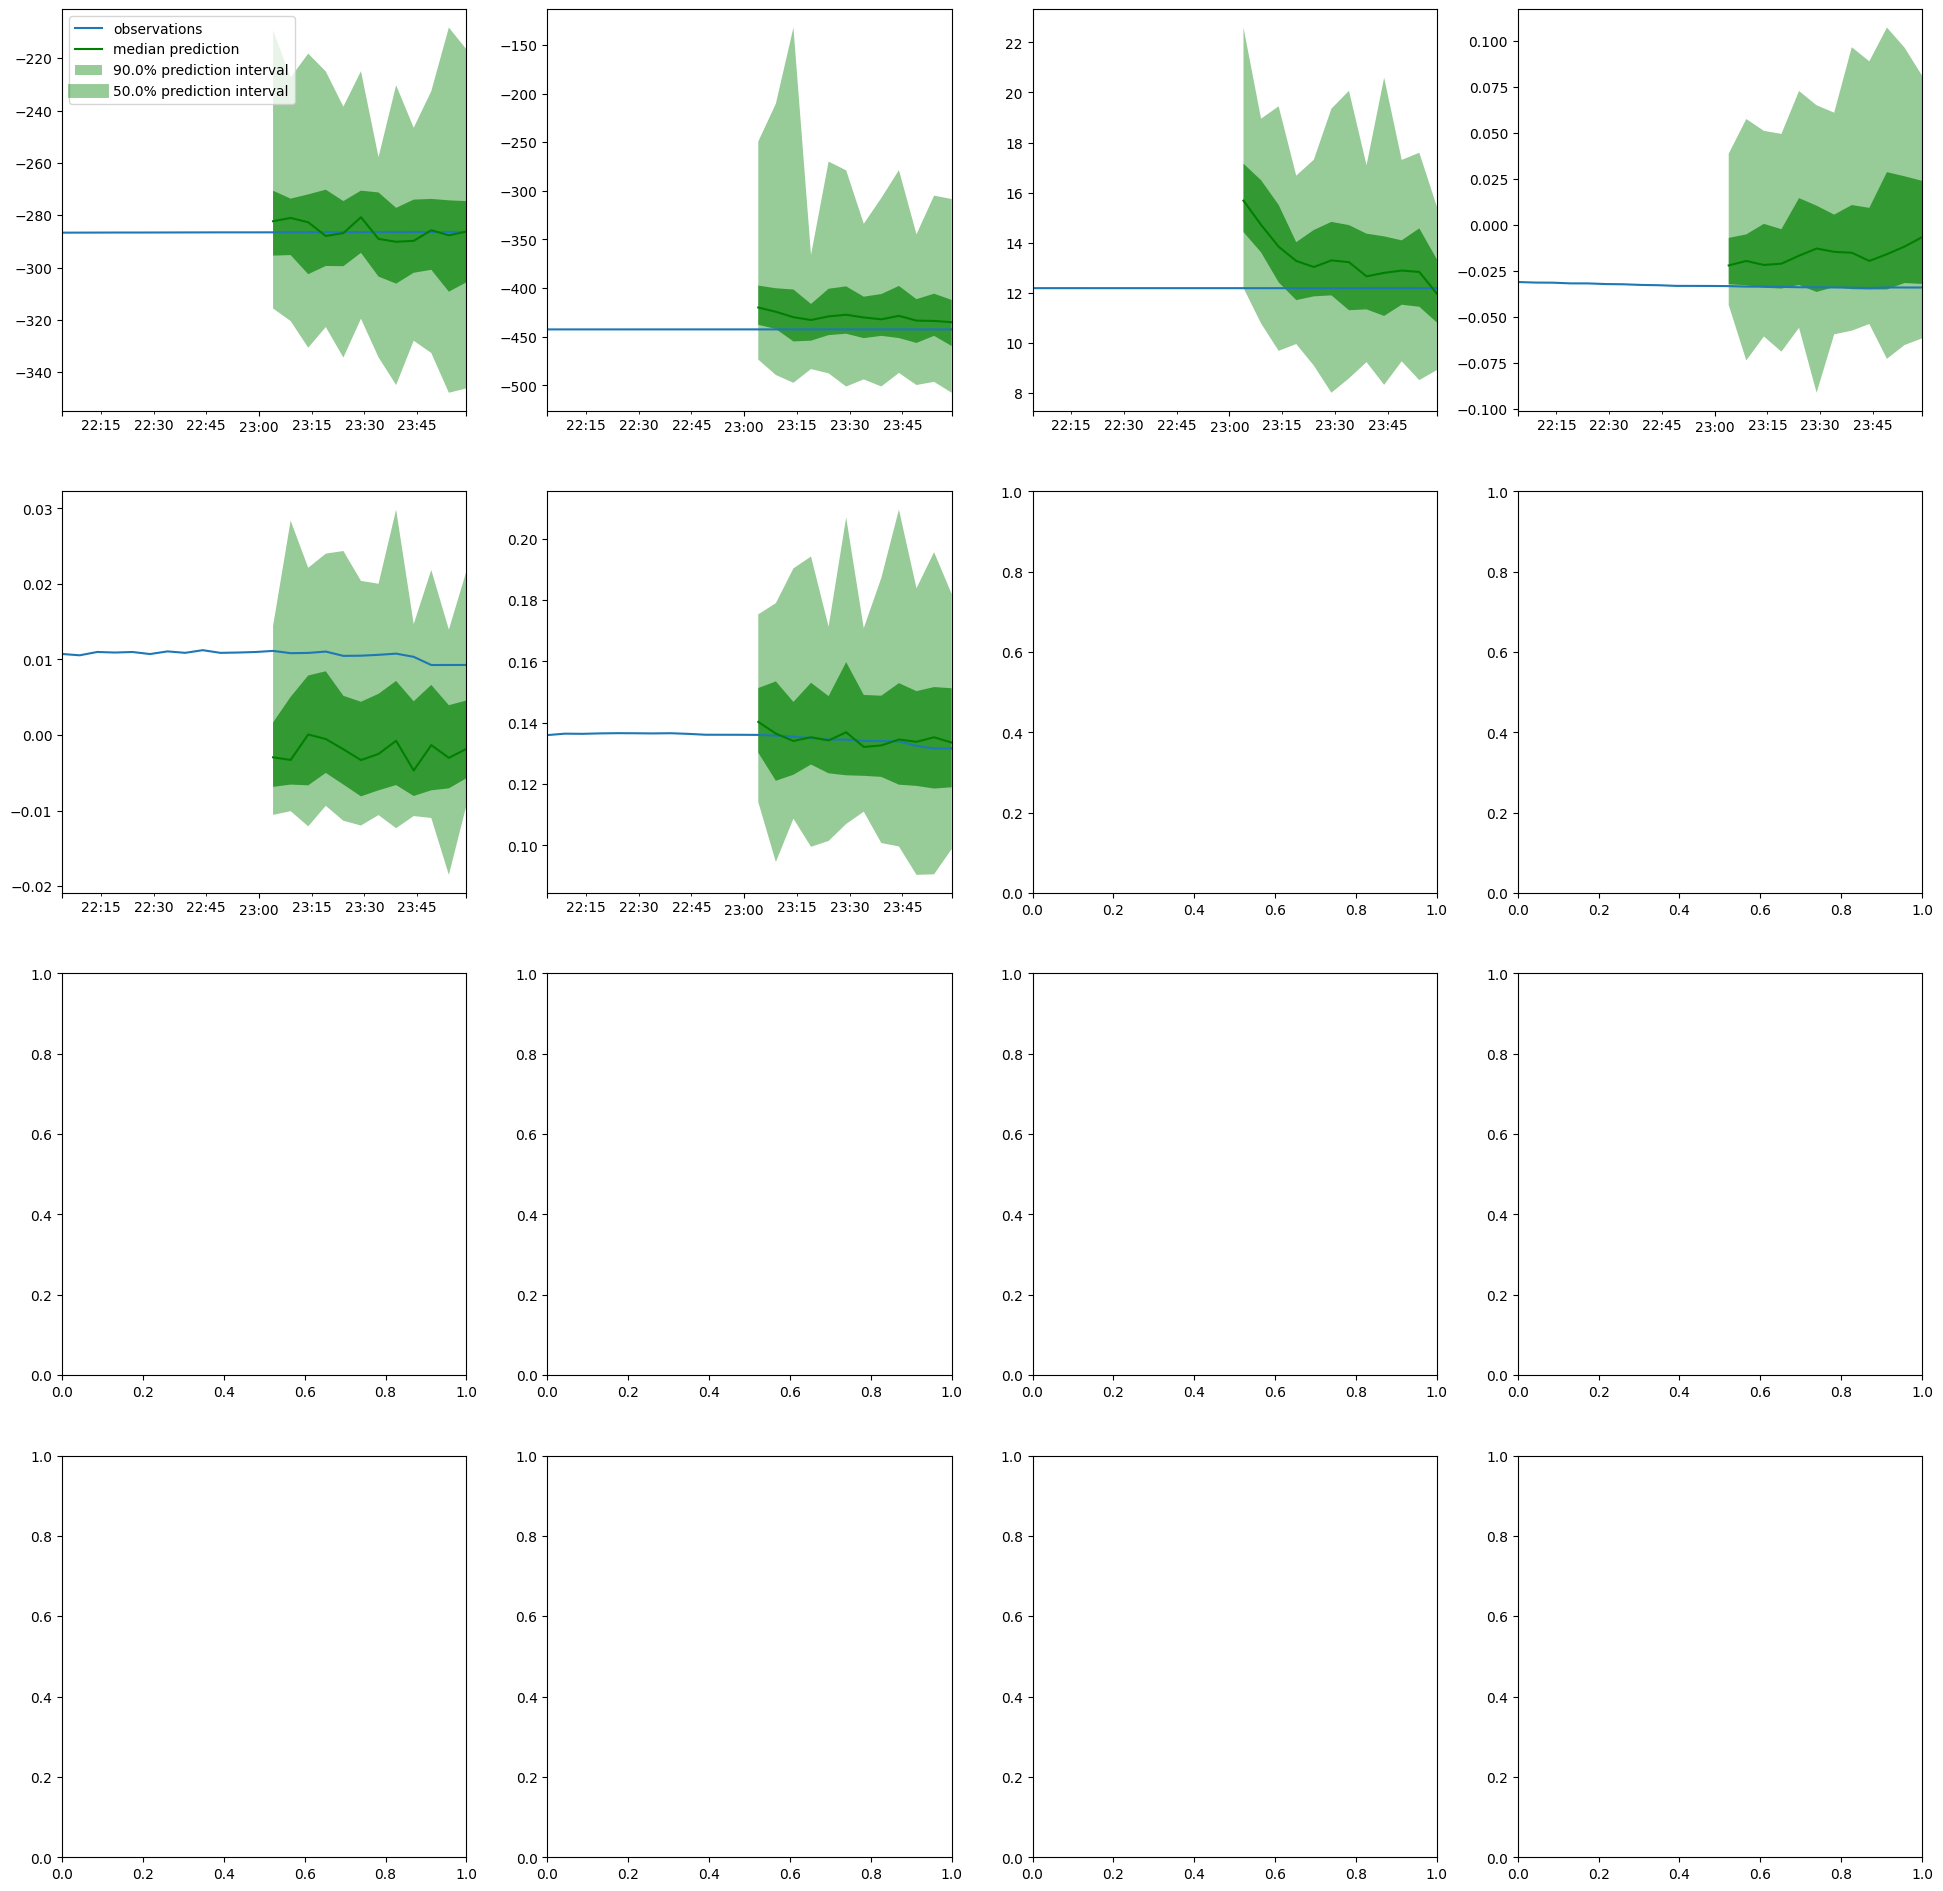

In [175]:
print("NlctGt")

plot(
    target=targets_NlctGt[0],
    forecast=forecasts_NlctGt[0],
    prediction_length=12,
)
plt.show()

# 评估

In [170]:
evaluator = MultivariateEvaluator(quantiles=(np.arange(20)/20.0)[1:], 
                                  target_agg_funcs={'sum': np.sum})

In [171]:
agg_metric_NlctGt, item_metrics_NlctGt = evaluator(targets_NlctGt, forecasts_NlctGt, num_series=len(test_data))


Running evaluation: 1it [00:00, 39.23it/s]
Running evaluation: 1it [00:00, 101.15it/s]
Running evaluation: 1it [00:00, 103.69it/s]


Running evaluation: 1it [00:00, 98.79it/s]
Running evaluation: 1it [00:00, 106.04it/s]
Running evaluation: 1it [00:00, 103.36it/s]
Running evaluation: 1it [00:00, 63.32it/s]


In [172]:
print("NlctGt Results")
print("CRPS:", agg_metric_NlctGt["mean_wQuantileLoss"])
print("ND:", agg_metric_NlctGt["ND"])
print("NRMSE:", agg_metric_NlctGt["NRMSE"])
print("MSE:", agg_metric_NlctGt["MSE"])
print("")
print("CRPS-Sum:", agg_metric_NlctGt["m_sum_mean_wQuantileLoss"])
print("ND-Sum:", agg_metric_NlctGt["m_sum_ND"])
print("NRMSE-Sum:", agg_metric_NlctGt["m_sum_NRMSE"])

NlctGt Results
CRPS: 0.02519698547450774
ND: 0.022524393592103596
NRMSE: 0.11540782119891933
MSE: 203.297231370854

CRPS-Sum: 0.0212773314716877
ND-Sum: 0.022746949333677945
NRMSE-Sum: 0.05678320413583333
